In [1]:
%matplotlib notebook 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import psycopg2
import json

In [3]:
dbconf = None
with open('/Users/atfienberg/g-2/sipmometer/config/dbconnection.json', 'r') as f:
    dbconf = json.load(f)

In [4]:
cnx = psycopg2.connect(user=dbconf['user'], password=dbconf['password'],
                                  host=dbconf['host'],
                                  database=dbconf['dbname'], port=dbconf['port'])
cursor=cnx.cursor()
cursor.execute("select value, time from g2sc_values where channel='calo21temps'")
sipmnames = ['SiPM{}'.format(i) for i in range(54)] 
temps, times = zip(*cursor)

cursor.close()
cnx.close()

# build pandas dataframe
tempframe = pd.DataFrame(np.array(temps), columns=sipmnames, index=np.array(times))
# mask out failed reads
tempframe = tempframe[(tempframe > 20) & (tempframe < 50)]
tempframe[:3]

,SiPM0,SiPM1,SiPM2,SiPM3,SiPM4,SiPM5,SiPM6,SiPM7,SiPM8,SiPM9,...,SiPM44,SiPM45,SiPM46,SiPM47,SiPM48,SiPM49,SiPM50,SiPM51,SiPM52,SiPM53
2017-02-09 10:19:45.674560,NaN,31.0000,30.4375,31.25,31.1875,32.125,33.4375,34.2500,33.3750,NaN,...,35.9375,NaN,28.8125,30.0,30.8125,32.0,32.5,33.0625,33.5625,32.3125
2017-02-09 10:20:00.653777,NaN,31.0000,30.3750,31.25,31.1875,32.125,33.5000,34.3125,33.3125,NaN,...,35.9375,NaN,28.8125,30.0,30.8125,32.0,32.5,33.0000,33.5625,32.3125
2017-02-09 10:20:15.702132,NaN,30.9375,30.3750,31.25,31.1875,32.125,33.5000,34.2500,33.3125,NaN,...,35.8750,NaN,28.8125,30.0,30.8125,32.0,32.5,33.0625,33.5625,32.3750


<IPython.core.display.Javascript object>


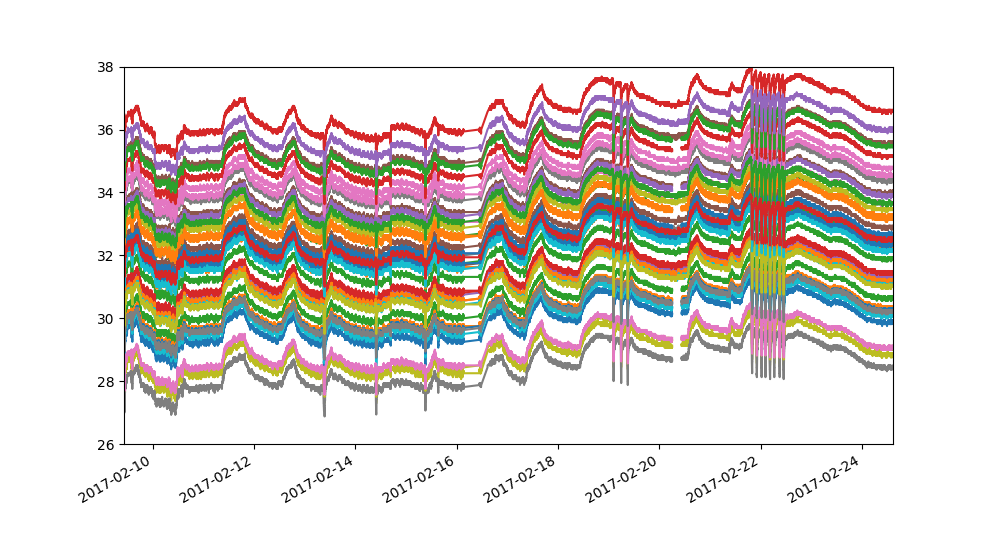

In [5]:
tempframe.plot(legend=False)
lims=plt.ylim(26,38)

<IPython.core.display.Javascript object>


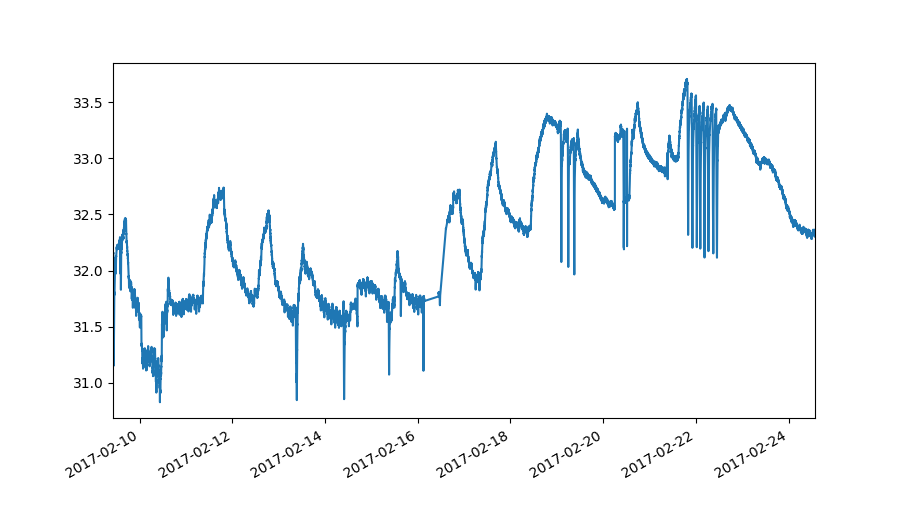

In [6]:
mean = tempframe.mean(1).plot()

<IPython.core.display.Javascript object>


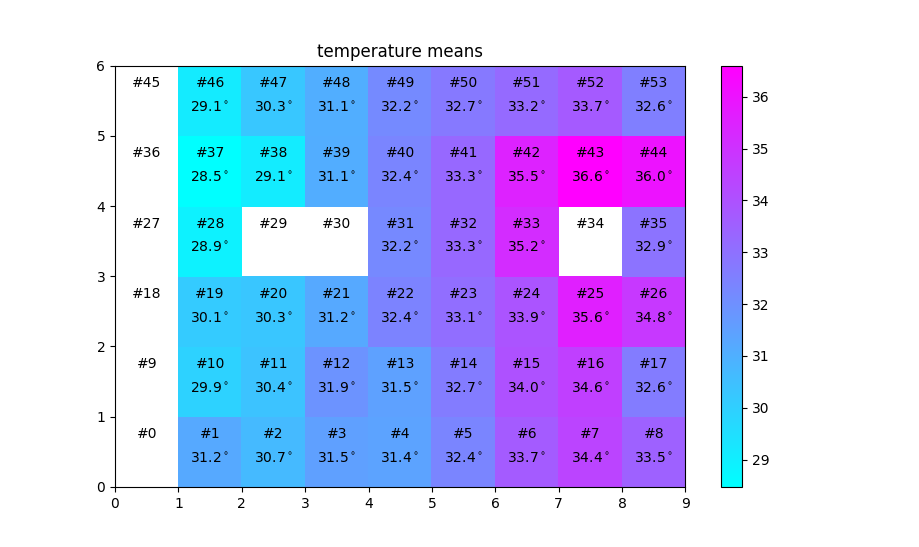

In [7]:
griddata = np.reshape(tempframe.mean().as_matrix(), (6,9))
griddata = np.ma.masked_invalid(griddata)
heatmap = plt.pcolor(griddata, cmap='cool')
plt.colorbar(heatmap)
for y in range(griddata.shape[0]):
    for x in range(griddata.shape[1]):
        val = griddata[y,x]          
        plt.text(x+0.5, y+0.75, '#{}'.format(y*9+x), horizontalalignment='center', verticalalignment='center')
        if val > 0.1:
            plt.text(x+0.5, y+0.4, '{:.1f}$^\circ$'.format(val), horizontalalignment='center', verticalalignment='center')
title=plt.title('temperature means')

<IPython.core.display.Javascript object>


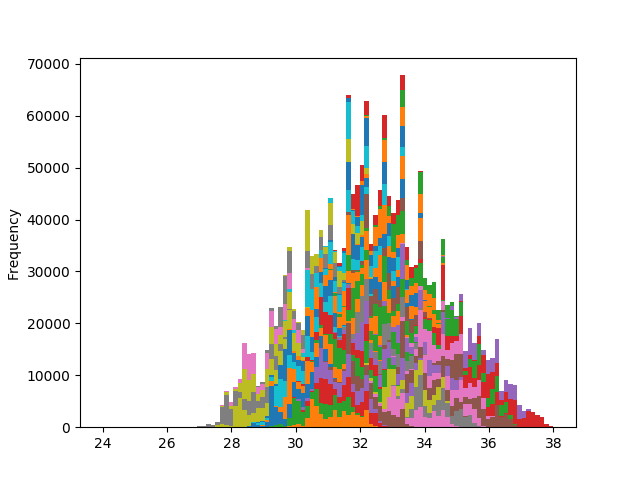

In [8]:
hists = tempframe.plot.hist(stacked=True, legend=False, bins=100)

<IPython.core.display.Javascript object>


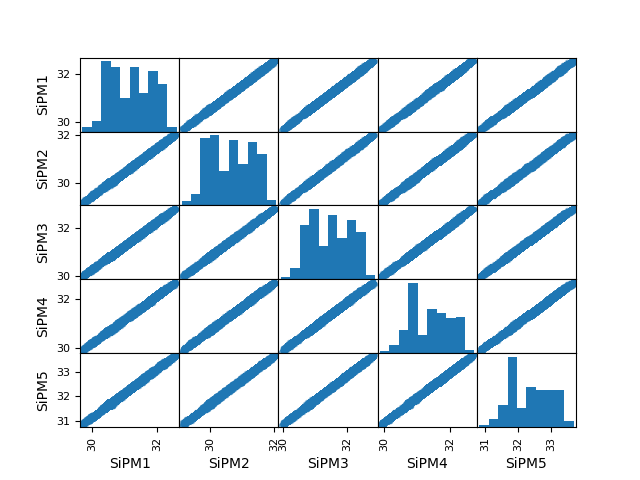

In [9]:
from pandas.tools.plotting import scatter_matrix
scatter_plots = scatter_matrix(tempframe.iloc[:,1:6])

<IPython.core.display.Javascript object>


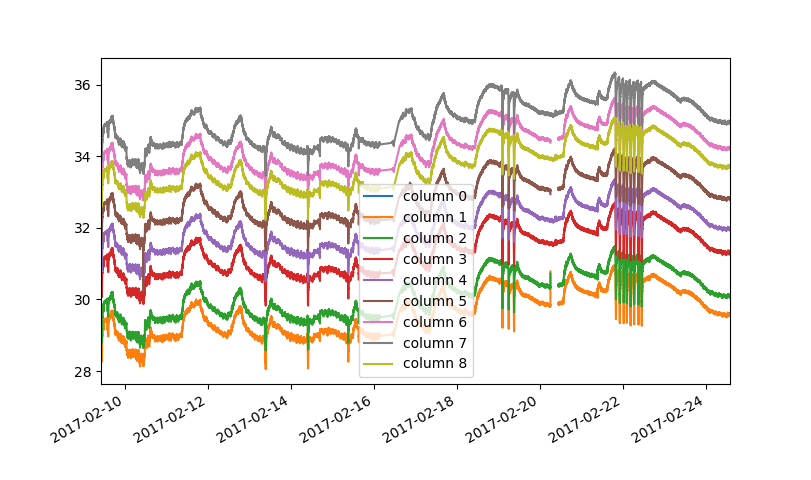

In [10]:
for i in range(9):
    tempframe['column {}'.format(i)] = tempframe.iloc[:,i::9].mean(1)
tempframe.loc[:,'column 0':'column 8'].plot()
plt.legend(loc='best')

<IPython.core.display.Javascript object>


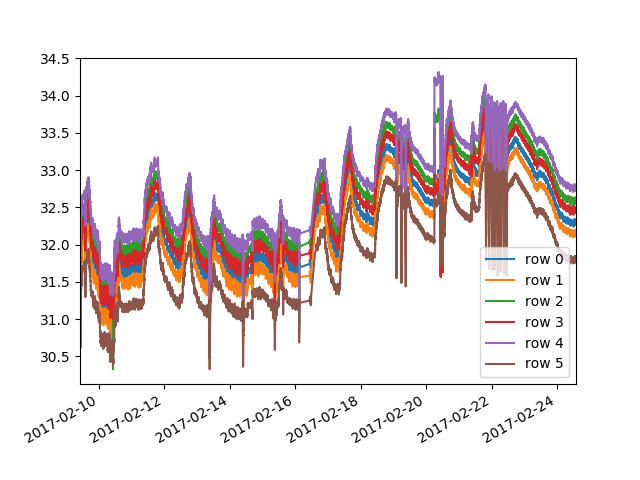

,column 0,column 1,column 2,column 3,column 4,column 5,column 6,column 7,column 8,row 0,row 1,row 2,row 3,row 4,row 5
2017-02-09 10:19:45.674560,NaN,29.364583,29.8750,31.0875,31.802083,32.6500,34.052083,34.8375,33.552083,32.132812,31.976562,32.410714,32.2750,32.585938,31.632812
2017-02-09 10:20:00.653777,NaN,29.333333,29.8625,31.1125,31.802083,32.6375,34.062500,34.8375,33.541667,32.132812,31.960938,32.410714,32.2750,32.585938,31.625000
2017-02-09 10:20:15.702132,NaN,29.343750,29.8750,31.1125,31.791667,32.6625,34.062500,34.8375,33.562500,32.117188,31.984375,32.410714,32.2875,32.593750,31.640625


In [12]:
for i in range(6):
    tempframe['row {}'.format(i)] = tempframe.iloc[:,9*i:9*(i+1)].mean(1)
tempframe.loc[:,'row 0':'row 5'].plot()
tempframe.iloc[:3,54:]

In [13]:
rebinned = tempframe.groupby([i//10 for i, val in enumerate(tempframe.index)]).mean()

<IPython.core.display.Javascript object>


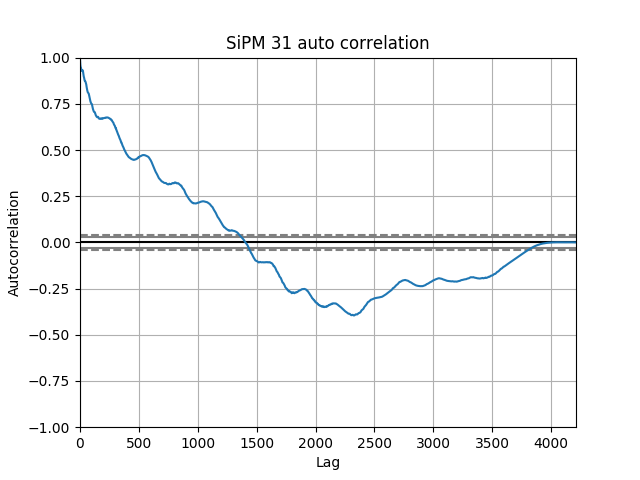

In [14]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(rebinned['SiPM31'])
plt.title('SiPM 31 auto correlation')

In [15]:
for name in tempframe.columns[pd.isnull(tempframe.sum())]:
    print('{} is all NaNs'.format(name))

SiPM0 is all NaNs
SiPM9 is all NaNs
SiPM18 is all NaNs
SiPM27 is all NaNs
SiPM29 is all NaNs
SiPM30 is all NaNs
SiPM34 is all NaNs
SiPM36 is all NaNs
SiPM45 is all NaNs
column 0 is all NaNs


In [18]:
resampled = tempframe.resample('5T').mean()
resampled[:3]

,SiPM0,SiPM1,SiPM2,SiPM3,SiPM4,SiPM5,SiPM6,SiPM7,SiPM8,SiPM9,...,column 5,column 6,column 7,column 8,row 0,row 1,row 2,row 3,row 4,row 5
2017-02-09 10:15:00,NaN,31.000000,30.437500,31.250000,31.187500,32.125000,33.437500,34.250000,33.375000,NaN,...,32.650000,34.052083,34.837500,33.552083,32.132812,31.976562,32.410714,32.275000,32.585938,31.632812
2017-02-09 10:20:00,NaN,30.959375,30.403125,31.240625,31.175000,32.121875,33.487500,34.271875,33.334375,NaN,...,32.642500,34.055729,34.820625,33.546354,32.124219,31.954687,32.399554,32.263750,32.580469,31.624219
2017-02-09 10:25:00,NaN,30.635417,30.046875,30.895833,30.828125,31.786458,33.166667,33.979167,33.026042,NaN,...,32.319792,33.750000,34.531250,33.245660,31.795573,31.600260,32.066220,31.911458,32.244792,31.276693


<IPython.core.display.Javascript object>


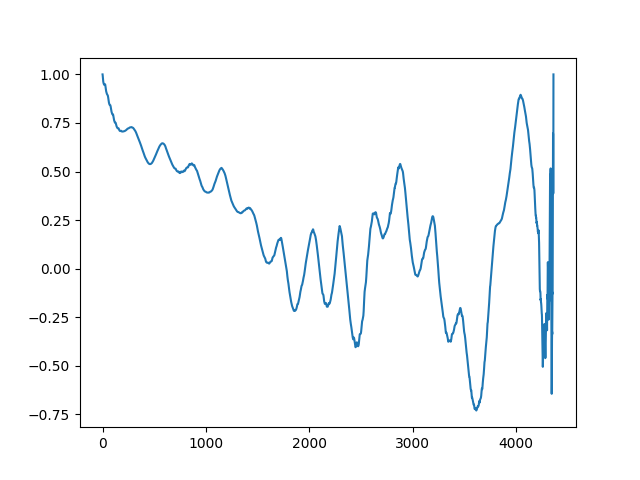

In [19]:
plt.plot([resampled['SiPM1'].autocorr(i) for i, t in enumerate(resampled.index[1:])])

<IPython.core.display.Javascript object>


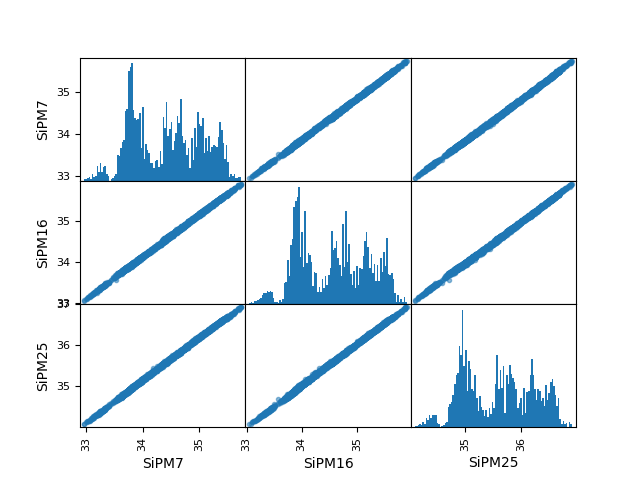

In [20]:
from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(resampled.iloc[:,7:26:9], diagonal='hist', hist_kwds={'bins':100})

<IPython.core.display.Javascript object>


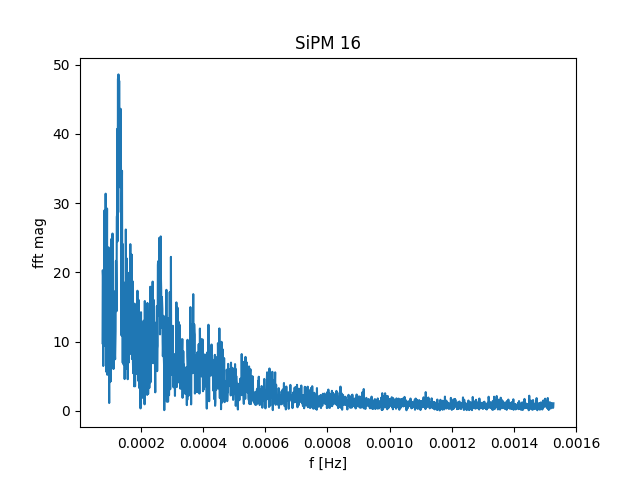

In [21]:
s16 = resampled['SiPM16'].fillna(method='ffill')
plt.plot(np.fft.fftfreq(s16.size, d=5*60)[100:2000], np.absolute(np.fft.fft(s16))[100:2000])
plt.xlabel('f [Hz]')
plt.ylabel('fft mag')
plt.title('SiPM 16')

In [26]:
temps[0]

[0.0,
 31.0,
 30.4375,
 31.25,
 31.1875,
 32.125,
 33.4375,
 34.25,
 33.375,
 0.0,
 29.6875,
 30.125,
 31.6875,
 31.25,
 32.4375,
 33.8125,
 34.4375,
 32.375,
 0.0,
 29.875,
 30.0,
 30.9375,
 32.25,
 0.0,
 33.6875,
 35.5,
 34.625,
 0.0,
 28.625,
 511.992,
 0.0,
 32.0,
 33.0625,
 35.0,
 0.0,
 32.6875,
 0.0,
 28.1875,
 28.8125,
 30.75,
 32.125,
 33.125,
 35.3125,
 36.4375,
 35.9375,
 0.0,
 28.8125,
 30.0,
 30.8125,
 32.0,
 32.5,
 33.0625,
 33.5625,
 32.3125]

In [27]:
times

(datetime.datetime(2017, 2, 9, 10, 19, 45, 674560),
 datetime.datetime(2017, 2, 9, 10, 20, 0, 653777),
 datetime.datetime(2017, 2, 9, 10, 20, 15, 702132),
 datetime.datetime(2017, 2, 9, 10, 20, 30, 651569),
 datetime.datetime(2017, 2, 9, 10, 20, 45, 761293),
 datetime.datetime(2017, 2, 9, 10, 21, 0, 895790),
 datetime.datetime(2017, 2, 9, 10, 21, 15, 925949),
 datetime.datetime(2017, 2, 9, 10, 21, 31, 46847),
 datetime.datetime(2017, 2, 9, 10, 21, 46, 115179),
 datetime.datetime(2017, 2, 9, 10, 22, 1, 107481),
 datetime.datetime(2017, 2, 9, 10, 22, 16, 160735),
 datetime.datetime(2017, 2, 9, 10, 22, 31, 93550),
 datetime.datetime(2017, 2, 9, 10, 22, 46, 92688),
 datetime.datetime(2017, 2, 9, 10, 23, 1, 220500),
 datetime.datetime(2017, 2, 9, 10, 23, 16, 306292),
 datetime.datetime(2017, 2, 9, 10, 23, 31, 336436),
 datetime.datetime(2017, 2, 9, 10, 23, 46, 477982),
 datetime.datetime(2017, 2, 9, 10, 24, 1, 469231),
 datetime.datetime(2017, 2, 9, 10, 24, 16, 552230),
 datetime.datetime(2